In [1]:
import sys

import numpy as np
import pandas as pd

from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

sys.path.append('..')
#from runner import MTTrainer
from losses import SPMTLoss

from warmup_scheduler import AddWarmup

%matplotlib inline
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [167]:
BS = 128
LR = 0.0001
MT = True
JSD = True
SPL = True
WD = 0.0005
EPOCHS = 100

## Two Moon Classification

This notebook will train a semi-supervised MT model to predict the class of the two moon dataset. Motivated by https://arxiv.org/abs/1804.09170

In [3]:
two_moons = make_moons(n_samples=1000, noise=0.1)

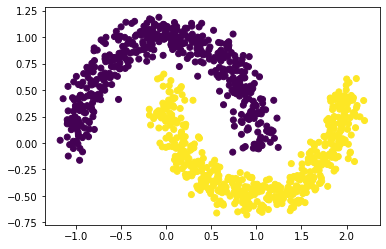

In [4]:
plt.scatter(two_moons[0][:,0], two_moons[0][:,1], c=two_moons[1])
plt.show()

### Divide the data into labeled an unlabled

In [5]:
def split_moons(labels):
    
    labeled_idx = []
    unlabeled_idx = np.array(range(len(labels)))
    
    for class_idx in range(2):
        idx = np.where(labels == class_idx)[0]
        idx = np.random.choice(idx, 4, replace=False)
        
        labeled_idx.extend(idx)
        
    labeled_idx = np.array(labeled_idx, dtype=np.int32)

    # make sure there is no overlap in supervised and unsupervised
    unlabeled_idx = np.array([x for x in unlabeled_idx if x not in labeled_idx], dtype=np.int32)

    print(len(unlabeled_idx), len(labeled_idx))

    return labeled_idx, unlabeled_idx

In [6]:
labeled_idx, unlabled_idx = split_moons(two_moons[1])

992 8


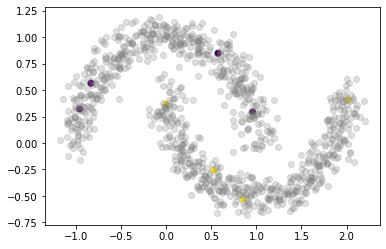

In [7]:
plt.scatter(two_moons[0][labeled_idx,0], two_moons[0][labeled_idx,1], c=two_moons[1][labeled_idx])
plt.scatter(two_moons[0][unlabled_idx,0], two_moons[0][unlabled_idx,1], color='grey', alpha=0.25)
plt.show()

In [110]:
moons, labels = two_moons[0], two_moons[1]
labels[unlabled_idx] = -1

In [168]:
class SemiSupervisedDataset(Dataset):
    def __init__(
        self,
        moons, 
        labels,
        balance_rate: float = 0.25
    ):
        self.moons = moons
        self.labels = labels
        self.balance_rate = balance_rate
        
    def __getitem__(self, _: int) -> dict:

        if np.random.random() > self.balance_rate:
            # choose an unlabeled moon
            indices = np.where(self.labels == -1)[0]
        else:
            # choose a labeled moon
            indices = np.where(self.labels != -1)[0]

        idx = np.random.choice(indices)

        return {
            'moon': torch.tensor(self.augment(self.moons[idx])).float(),
            'ema_moon': torch.tensor(self.augment(self.moons[idx])).float(),
            'targ': torch.tensor(self.labels[idx]),
        }

    def __len__(self):
        return len(self.moons)
    
    def augment(self, x):
        return x + np.random.normal(0, 0.025, size=2)

moon_ds = SemiSupervisedDataset(moons, labels)

# set up the data loader
train_loader = DataLoader(
    moon_ds,
    batch_size=BS,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

### Develop the neural network to classify these points

In [169]:
class MoonNet(nn.Module):
    def __init__(self):
        super(MoonNet, self).__init__()
        
        self.layer_a = nn.Linear(2, 64)
        self.layer_b = nn.Linear(64, 64)
        self.class_out = nn.Linear(64, 2)
        self.cons_out = nn.Linear(64, 2)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.leaky_relu(self.layer_a(x))
        x = F.leaky_relu(self.layer_b(x))
        x = self.dropout(x)
        
        class_out = self.class_out(x)
        #cons_out = self.cons_out(x)
        
        return class_out

In [170]:
# SSL models
net = MoonNet()
ema_net = MoonNet()
# supervised model
sup_net = MoonNet()

In [171]:
optimizer = optim.AdamW(
    net.parameters(),
    lr = LR,
    weight_decay = WD,
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = EPOCHS * len(train_loader),
    eta_min = 0.,
    verbose = False
)

sup_optimizer = optim.AdamW(
    sup_net.parameters(),
    lr = LR,
    weight_decay = WD,
)

sup_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    sup_optimizer,
    T_max = EPOCHS * len(train_loader),
    eta_min = 0.,
    verbose = False
)

In [172]:
class SPMTLoss(nn.Module):
    def __init__(self, warmup_iterations):
        super(SPMTLoss, self, ).__init__()
        self.iterations = 0.
        self.warmup_iterations = warmup_iterations

        self.class_crit = nn.CrossEntropyLoss(size_average='mean', ignore_index=-1, label_smoothing=0.1)

    def forward(
        self,
        pred: torch.Tensor,
        targ_class: torch.Tensor,
        ema_logit: torch.Tensor,
        aug_pred: torch.Tensor
    ):
        n = pred.size(0)
        n_class = pred.size(1)

        supervised_loss = self.class_crit(pred, targ_class)

        if (ema_logit is not None):
            
            unsupervised_loss = F.mse_loss(
                F.softmax(pred[1], -1),
                F.softmax(ema_logit, -1),
                size_average='none'
            )

            
            if SPL:
                entropy = torch.special.entr(F.softmax(ema_logit,-1)).sum(-1)
                attn = F.softmax(-entropy, -1)
                
                unsupervised_loss = (unsupervised_loss.mean(-1) * attn).sum()
            else:
                unsupervised_loss = unsupervised_loss.mean()
            
            #with torch.no_grad():
            #    unsup_lambda = supervised_loss.item() / (unsupervised_loss.item() + 1e-8)

            unsup_lambda = 10. * self.rampup()
            unsupervised_loss = unsup_lambda * unsupervised_loss
        else:
            unsupervised_loss = torch.tensor([0.]).to(pred.device)

        if JSD and aug_pred is not None:
            jsd_loss = 15. * self.rampup() * self.jsd_loss(pred, aug_pred)
        else:
            jsd_loss = torch.tensor([0.]).to(pred.device)

        res_loss = torch.tensor([0.]).to(pred.device) #0.01 * self.symmetric_mse_loss(pred[0], pred[1])

        self.iterations += 1

        return supervised_loss, unsupervised_loss, res_loss, jsd_loss

    def rampup(self):
        return min(1., (float(self.iterations) / self.warmup_iterations))

    def entropy(self, dist):
        return -1 * torch.sum((dist + 1e-8) * torch.log(dist + 1e-8), axis=-1)

    def symmetric_mse_loss(self, input_a, input_b):
        assert input_a.size() == input_b.size()

        return torch.mean((input_a - input_b)**2)

    def jsd_loss(self, input_a, input_b):

        kl_targ = (F.softmax(input_a, -1) + F.softmax(input_b, -1)) / 2.

        kl_sum = (
            F.kl_div(F.log_softmax(input_a, -1), kl_targ.detach(), reduction='batchmean') +
            F.kl_div(F.log_softmax(input_b, -1), kl_targ.detach(), reduction='batchmean')
        )

        jsd_loss = 0.5 * (kl_sum)

        return jsd_loss
    
crit = SPMTLoss(warmup_iterations = 10. * len(train_loader))

### Set up the training functions

In [173]:
def update_teacher(net, ema_net, iterations, alpha=0.99):
    # use regular average until model weights stabilize
    alpha = min(1 - 1 / (iterations + 1), alpha)

    for param_t, param_s in zip(ema_net.parameters(), net.parameters()):
        param_t.data *= alpha                       # previous data multiplied by weight
        param_t.data += param_s.data * (1. - alpha) # new data multiplied by inv weight
        
    return ema_net

In [174]:
def run_epoch(net, ema_net, epoch: int, iterations: float) -> None:

    running_loss = 0.
    running_total = 0
    running_corrects = 0

    running_unsup_loss = 0.


    # zero gradients
    optimizer.zero_grad(set_to_none = True)
    net.train(True)
    ema_net.train(True)

    iterator = enumerate(train_loader)
    n_batches = len(train_loader)

    for i, data in iterator:
        imgs, targets = data['moon'], data['targ']
        #imgs, targets = imgs.to(device), targets.to(device)

        if MT:
            ema_imgs = data['ema_moon']
            #ema_imgs = ema_imgs.to(device)

            with torch.no_grad():
                ema_logit = ema_net(ema_imgs)

            aug_preds = net(ema_imgs)
        else:
            ema_logit = None
            aug_preds = None

        # get predictions
        preds = net(imgs)

        # calculate loss
        supervised_loss, consistency_loss, res_loss, jsd_loss = crit(preds, targets, ema_logit, aug_preds)

        loss = supervised_loss + consistency_loss + res_loss + jsd_loss

        running_unsup_loss += consistency_loss.item()

        # track classification accuracy
        predicted = torch.argmax(preds, 1)
        mask = targets.ne(-1)
        total = max(mask.sum().item(), 1e-8)
        correct = (predicted[mask] == targets[mask]).sum().item()

        running_loss += loss.item()
        running_total += total
        running_corrects += correct


        # zero gradients
        optimizer.zero_grad(set_to_none=True)

        loss.backward()
        
        iterations += 1
        
        # update weights
        optimizer.step()
        scheduler.step()

        if MT:
            # update teacher
            ema_net = update_teacher(net, ema_net, iterations)

        # make a cool terminal output
        sys.stdout.write('\r')
        sys.stdout.write('B: {:>3}/{:<3} | Class: {:.3} | Cons: {:.3} | Res: {:.3} | JSD: {:.3}'.format(
            i+1,
            n_batches,
            supervised_loss.item(),
            consistency_loss.item(),
            res_loss.item(),
            jsd_loss.item()
        ))
        sys.stdout.flush()
        
        # update the purely supervised model
        sup_preds = sup_net(imgs)
        sup_loss = F.cross_entropy(sup_preds, targets, ignore_index=-1, label_smoothing=0.1)
        # zero gradients
        sup_optimizer.zero_grad(set_to_none=True)
        sup_loss.backward()
        # update weights
        sup_optimizer.step()
        sup_scheduler.step()


    print(
        '\n' + 'Avg Loss: {:.4}  Acc: {:.2} | Unsup Loss: {:.4}'.format(
            running_loss / n_batches,
            running_corrects / running_total,
            running_unsup_loss / n_batches
        )
    )


In [175]:
try:
    iterations = 0.
    for e in range(EPOCHS):

        print('\n' + 'Iter {}/{}'.format(e + 1, EPOCHS))

        _ = run_epoch(net, ema_net, epoch = e, iterations = iterations)

except KeyboardInterrupt:
    pass


Iter 1/100
B:   8/8   | Class: 0.718 | Cons: 0.00105 | Res: 0.0 | JSD: 0.0014167
Avg Loss: 0.7274  Acc: 0.36 | Unsup Loss: 0.0009686

Iter 2/100


/tmp/ipykernel_241417/184752425.py:23: UserWarning: Using a target size (torch.Size([128, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  unsupervised_loss = F.mse_loss(
/tmp/ipykernel_241417/184752425.py:23: UserWarning: Using a target size (torch.Size([104, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  unsupervised_loss = F.mse_loss(


B:   8/8   | Class: 0.715 | Cons: 0.00311 | Res: 0.0 | JSD: 0.00422
Avg Loss: 0.7198  Acc: 0.46 | Unsup Loss: 0.005448

Iter 3/100
B:   8/8   | Class: 0.708 | Cons: 0.0101 | Res: 0.0 | JSD: 0.004674
Avg Loss: 0.7121  Acc: 0.48 | Unsup Loss: 0.005698

Iter 4/100
B:   8/8   | Class: 0.712 | Cons: 0.0139 | Res: 0.0 | JSD: 0.009357
Avg Loss: 0.7164  Acc: 0.48 | Unsup Loss: 0.007428

Iter 5/100
B:   8/8   | Class: 0.661 | Cons: 0.00949 | Res: 0.0 | JSD: 0.01139
Avg Loss: 0.7019  Acc: 0.6 | Unsup Loss: 0.014

Iter 6/100
B:   8/8   | Class: 0.704 | Cons: 0.0152 | Res: 0.0 | JSD: 0.01174
Avg Loss: 0.7117  Acc: 0.56 | Unsup Loss: 0.01433

Iter 7/100
B:   8/8   | Class: 0.678 | Cons: 0.0993 | Res: 0.0 | JSD: 0.0117
Avg Loss: 0.7166  Acc: 0.63 | Unsup Loss: 0.03084

Iter 8/100
B:   8/8   | Class: 0.661 | Cons: 0.0151 | Res: 0.0 | JSD: 0.0139
Avg Loss: 0.6994  Acc: 0.66 | Unsup Loss: 0.01706

Iter 9/100
B:   8/8   | Class: 0.672 | Cons: 0.0466 | Res: 0.0 | JSD: 0.0157
Avg Loss: 0.7138  Acc: 0.61 |

In [176]:
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(moons.min() - 1, moons.max() + 1, h),
                     np.arange(moons.min() - 1, moons.max() + 1, h))

In [177]:
test_feats = np.c_[xx.ravel(), yy.ravel()]

ema_net.eval()
sup_net.eval()

preds = torch.argmax(ema_net(torch.Tensor(test_feats).float()), -1)
sup_preds = torch.argmax(sup_net(torch.Tensor(test_feats).float()), -1)

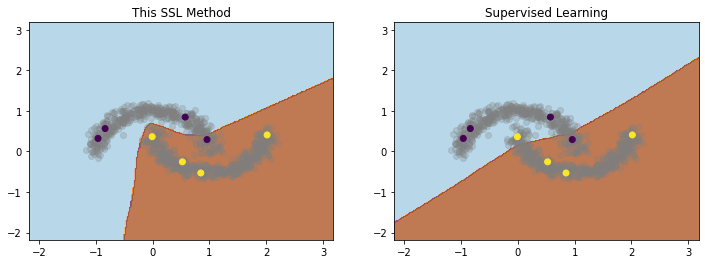

In [178]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

ax[0].set_title('This SSL Method')
ax[0].contourf(xx, yy, preds.numpy().reshape(xx.shape), cmap=plt.cm.Paired, alpha=0.8)
ax[0].scatter(two_moons[0][unlabled_idx,0], two_moons[0][unlabled_idx,1], color='grey', alpha=0.25)
ax[0].scatter(two_moons[0][labeled_idx,0], two_moons[0][labeled_idx,1], c=two_moons[1][labeled_idx])


ax[1].set_title('Supervised Learning')
ax[1].contourf(xx, yy, sup_preds.numpy().reshape(xx.shape), cmap=plt.cm.Paired, alpha=0.8)
ax[1].scatter(two_moons[0][unlabled_idx,0], two_moons[0][unlabled_idx,1], color='grey', alpha=0.25)
ax[1].scatter(two_moons[0][labeled_idx,0], two_moons[0][labeled_idx,1], c=two_moons[1][labeled_idx])


plt.savefig('../imgs/decision_bounds.png')